In [1]:
import numpy as np
import torch
from torch import nn

## Signal propagation


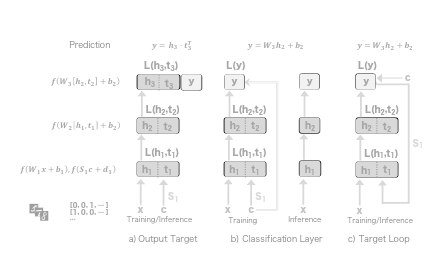


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [85]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [26]:
batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64


In [83]:
torch.autograd.set_detect_anomaly(True)
# sig prop class
class sigprop(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.target_gen = nn.Linear(10,16)
        
        self.w1 = nn.Linear(28*28,16)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, c):
        
        x = self.flatten(x)
        c = nn.functional.one_hot(c)
        c = c.to(torch.float32)

        h1 = self.w1(x)
        t1 = self.target_gen(c)
        T = torch.stack((h1,t1), 0)
        h_prev = h1
        t_prev = t1
        # updating parameters
        for l in self.linear_relu_stack:

            hl = l(h_prev)
            tl = l(t_prev)
            
            loss = self.loss_fn(hl,tl)
            loss.backward(retain_graph=True)
            print(loss)
            
#             print('before update'.format(list(l.parameters())))
        
            with torch.no_grad():  
                for param in l.parameters():
                    param -= 1e-6 * param.grad

#             print('after update'.format(list(l.parameters().grad)))
            
            h_prev = hl
            t_prev=tl
        return T

In [84]:
net = sigprop()
logit = net(X,y)
logit.shape

tensor(0.1104, grad_fn=<DivBackward1>)


/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
    self.io_loop.start()
  File "/home/rufael.marew/.conda/envs/sig_prop/lib/python3.8/site-packages/

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [16, 4]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!